# Carvana EDA

## Подключение библиотек и загрузка датасета

In [ ]:
!pip install segmentation_models_pytorch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import numpy as np
import glob
import segmentation_models_pytorch as smp

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c carvana-image-masking-challenge
!unzip /content/train.zip -d /content/train
!unzip /content/test.zip -d /content/test
!unzip /content/metadata.csv.zip -d /content/
!unzip /content/train_masks.zip -d /content/train_masks
!unzip /content/train_masks.csv.zip -d /content/
!unzip /content/sample_submission.csv.zip -d /content/

## Исследование датасета

In [ ]:
train_files = !find /content/train -type f| wc -l
train_masks_files = !find /content/train_masks -type f| wc -l
test_files = !find /content/test -type f| wc -l

In [ ]:
print(f"Number of files in train:       {train_files[0]}")
print(f"Number of files in train_masks: {train_masks_files[0]}")
print(f"Number of files in test:        {test_files[0]}")

Number of files in train:       5088
Number of files in train_masks: 5088
Number of files in test:        100064


### Исследование train_masks

In [ ]:
train_masks = pd.read_csv('/content/train_masks.csv')
train_masks.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [ ]:
print(f"rows in train_masks: {train_masks.shape[0]}")

rows in train_masks: 5088


In [ ]:
train_masks["car"] = train_masks["img"].apply(lambda x: x.split('_')[0])
print(f"Unique cars in train_masks: {train_masks['car'].nunique()}")

Unique cars in train_masks: 318


В train_masks по 16 масок для каждого изображения (всего 5088)

### Исследование sample_submission

In [ ]:
sample_submission = pd.read_csv('/content/metadata.csv')
sample_submission.head()

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [ ]:
print(f"rows in sample_submission: {sample_submission.shape[0]}")

rows in sample_submission: 100064


In [ ]:
sample_submission["car"] = sample_submission["img"].apply(lambda x: x.split('_')[0])
print(f"Unique cars in sample_submission: {sample_submission['car'].nunique()}")

Unique cars in sample_submission: 6254


В sample_submission по 16 масок для каждого изображения (всего 100064)

Для отравки submit нужен конвертер из изображения маски в rle

### Исследование metadata

In [ ]:
metadata = pd.read_csv('/content/metadata.csv')
metadata.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [ ]:
print(f"rows in metadata: {metadata.shape[0]}")
print(f"uniq cars in metadata: {metadata['id'].nunique()}")

rows in metadata: 6572
uniq cars in metadata: 6572


Всего в metadata 6572 уникальных автомобиля, в train_masks - 318, в sample_submission - 6254

### Проверка отсутствия пересечений в train и test

In [ ]:
print(f"Number of intersects in train and test {np.isin(sample_submission['car'].unique(), train_masks['car'].unique()).sum()}")

Number of intersects in train and test 0


Пересечений в train и test нет. При разделении train на train и valid нужно придерживаться такой же стратегии.

## Создание DataFrame с адресами изображений для обучения и валидации

In [ ]:
# Получаем DataFrame data, содержащий адреса исходных изображений и соответсвующих им масок

files_path = '/content/train/train'
target_files_path = '/content/train_masks/train_masks'

data_files = {}
data_target = {}
data_files['files_path'] = []
data_target['target_files_path'] = []
data_files['files_path'] = list(glob.glob(files_path + "/*"))
data_target['target_files_path'] = list(glob.glob(target_files_path + "/*"))

data_files = pd.DataFrame(data_files)
data_target = pd.DataFrame(data_target)

def file_name(x):
    return x.split("/")[-1].split(".")[0]

data_files["file_name"] = data_files["files_path"].apply(lambda x: file_name(x))
data_target["file_name"] = data_target["target_files_path"].apply(lambda x: file_name(x)[:-5])

data = pd.merge(data_files, data_target, on = "file_name", how = "inner")
data.head()

# Добавить проверку через assert
print(f"Number of null elements: {data.isnull().sum().sum()}")
print(f"Number of duplicated rows: {data.duplicated().sum()}")

Number of null elements: 0
Number of duplicated rows: 0


In [ ]:
data.head()

,files_path,file_name,target_files_path
0,/content/train/train/5df60cf7cab2_04.jpg,5df60cf7cab2_04,/content/train_masks/train_masks/5df60cf7cab2_...
1,/content/train/train/a1038b207299_07.jpg,a1038b207299_07,/content/train_masks/train_masks/a1038b207299_...
2,/content/train/train/2af7c265531e_15.jpg,2af7c265531e_15,/content/train_masks/train_masks/2af7c265531e_...
3,/content/train/train/880ab8468df2_14.jpg,880ab8468df2_14,/content/train_masks/train_masks/880ab8468df2_...
4,/content/train/train/fce0ba5b8ed7_12.jpg,fce0ba5b8ed7_12,/content/train_masks/train_masks/fce0ba5b8ed7_...


In [ ]:
print(f"rows in data {data.shape[0]}")

rows in data 5088


In [ ]:
data["car"] = data["file_name"].apply(lambda x: x.split('_')[0])
print(f"Unique cars in data: {data['car'].nunique()}")

Unique cars in data: 318


 Имеем 5088 ссылок на изображения и 5088 ссылок на соответсвующие им маски

Количество уникальных машин в train_masks (из .csv) соответствует количеству в data (получено на основе предоставленных изображений)

## Исследование изображений

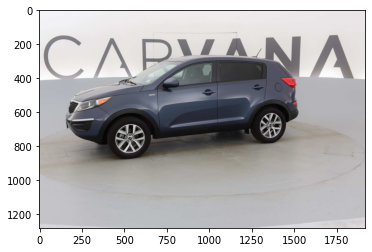

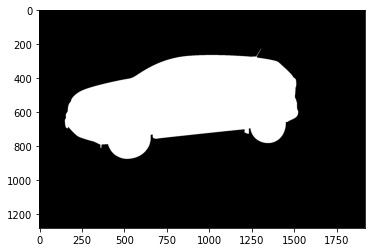

In [ ]:
img = plt.imread('/content/train/train/5df60cf7cab2_04.jpg')
plt.imshow(img)
plt.show()
mask = plt.imread('/content/train_masks/train_masks/5df60cf7cab2_04_mask.gif')
plt.imshow(mask)
plt.show()

In [ ]:
print(f"image shape: {img.shape}")
print(f"mask shape: {mask.shape}")

image shape: (1280, 1918, 3)
mask shape: (1280, 1918, 4)


Маски имеют 4 канала - нужно перейти к одному каналу, так как будем решать задачу бинарной классификации

In [ ]:
mask_channels = [mask[:,:,0], mask[:,:,1], mask[:,:,2], mask[:,:,3]]

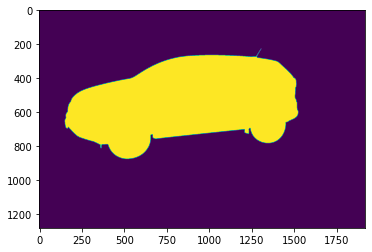

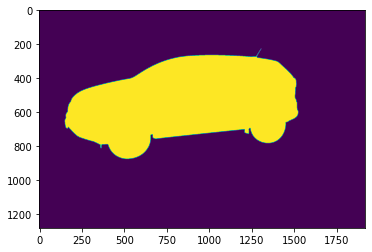

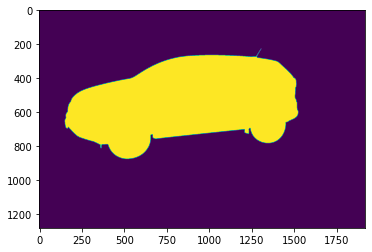

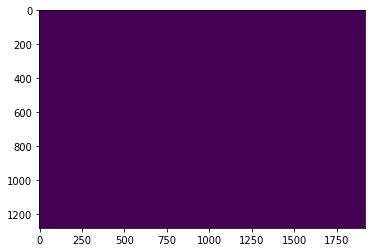

In [ ]:
# Выведем все 4 канала маски
for mask_channel in mask_channels:
    plt.imshow(mask_channel)
    plt.show()

### Проверим возможные значения в разных каналах масок и равенство каналов

In [ ]:
unique_ch_0, counts = np.unique(mask[:,:,0], return_counts=True)
unique_ch_1, counts = np.unique(mask[:,:,1], return_counts=True)
unique_ch_2, counts = np.unique(mask[:,:,2], return_counts=True)
unique_ch_3, counts = np.unique(mask[:,:,3], return_counts=True)

In [ ]:
print(f"Unique values in mask channel 0: {unique_ch_0}")
print(f"Unique values in mask channel 1: {unique_ch_1}")
print(f"Unique values in mask channel 2: {unique_ch_2}")
print(f"Unique values in mask channel 3: {unique_ch_3}")

Unique values in mask channel 0 [  0 255]
Unique values in mask channel 1 [  0 255]
Unique values in mask channel 2 [  0 255]
Unique values in mask channel 3 [255]


In [ ]:
print(f"Nonequal elements in channel 0 and 1: {(mask[:,:,0] != mask[:,:,1]).sum()}")
print(f"Nonequal elements in channel 0 and 2: {(mask[:,:,0] != mask[:,:,2]).sum()}")
print(f"Nonequal elements in channel 1 and 2: {(mask[:,:,1] != mask[:,:,2]).sum()}")

Nonequal elements in channel 0 and 1: 0
Nonequal elements in channel 0 and 2: 0
Nonequal elements in channel 1 and 2: 0


Каналы 0, 1 и 2 в масках одинаковые, поэтому в качестве target при обучении можно брать любой из первых 3-х каналов маски либо преобразовывать маску черно-белое изображение, но нужно будет проверить, что возможные значения элементов маски будут равны 0 или 1

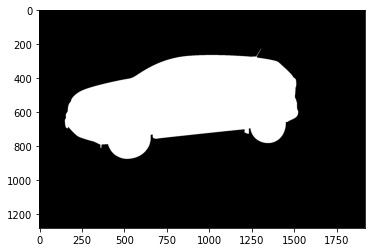

In [ ]:
# Преобразование в оттенки серого
mask = Image.open('/content/train_masks/train_masks/5df60cf7cab2_04_mask.gif').convert('LA')
plt.imshow(mask)
plt.show()